# 00 - Executive Summary (One-Page)

This notebook synthesizes context and key results for fast review.

## Disclaimer
> This dataset was collected in **2021** during the COVID-19 peak period.
> The sample is **small and non-probabilistic** (178 responses).
> The current objective is to demonstrate a professional Data Analyst implementation using historical real-world data.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', 200)


In [2]:
project_root = Path.cwd()
if not (project_root / 'data').exists() and (project_root.parent / 'data').exists():
    project_root = project_root.parent

processed_csv = project_root / 'data/processed/survey_analytics.csv'
if not processed_csv.exists():
    raise FileNotFoundError('data/processed/survey_analytics.csv not found. Run src/data/clean_survey.py first')

df = pd.read_csv(processed_csv)
print('Shape:', df.shape)
df.head(2)


Shape: (178, 24)


,timestamp_raw,gender,q1_current_state,q2_emotional_state,q3_impact,q4_problems,q5_help_seek,q6_pre_pandemic_state,q7_learned_new_skill,q8_learned_text,q9_future_normality,q10_stress,q11_optimism,q12_control,q13_protocols,q14_anxiety,q15_wellbeing_final,timestamp,q10_stress_score,q11_optimism_score,q12_control_score,q13_protocols_score,q14_anxiety_score,q15_wellbeing_score
0,2021-04-29 22:00:07.041,Hombre,Ni bien ni mal.,Regular,Negativa,Prefiero no decir.,NaN,Bien,No,NaN,Si,Casi siempre,De vez en cuando,Casi nunca,De vez en cuando,Casi nunca,Tal vez,2021-04-29 22:00:07.041,3,2.0,1.0,2.0,1.0,1.0
1,2021-04-30 03:10:30.453,Hombre,Bien,Regular,Negativa,No,NaN,Normal,Si,Idiomas,Si,Nunca,Siempre,De vez en cuando,Siempre,Casi nunca,Si,2021-04-30 03:10:30.453,0,4.0,2.0,4.0,1.0,2.0


In [3]:
def pct(series, value):
    valid = series.dropna()
    if len(valid) == 0:
        return np.nan
    return round((valid == value).mean() * 100, 2)

kpis = {
    'Responses analyzed': len(df),
    '% perceived negative impact': pct(df['q3_impact'], 'Negativa'),
    '% reporting problems (q4=Si)': pct(df['q4_problems'], 'Si'),
    '% at-risk final wellbeing (No/Tal vez)': round(df['q15_wellbeing_final'].isin(['No', 'Tal vez']).mean() * 100, 2),
}

kpi_df = pd.DataFrame(kpis.items(), columns=['Indicator', 'Value'])
kpi_df


,Indicator,Value
0,Responses analyzed,178.00
1,% perceived negative impact,51.98
2,% reporting problems (q4=Si),67.23
3,% at-risk final wellbeing (No/Tal vez),41.01


/tmp/ipykernel_43607/367452510.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='q3_impact', order=impact_order, ax=axes[0], palette='viridis')
/tmp/ipykernel_43607/367452510.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=well_series, order=well_order, ax=axes[1], palette='magma')


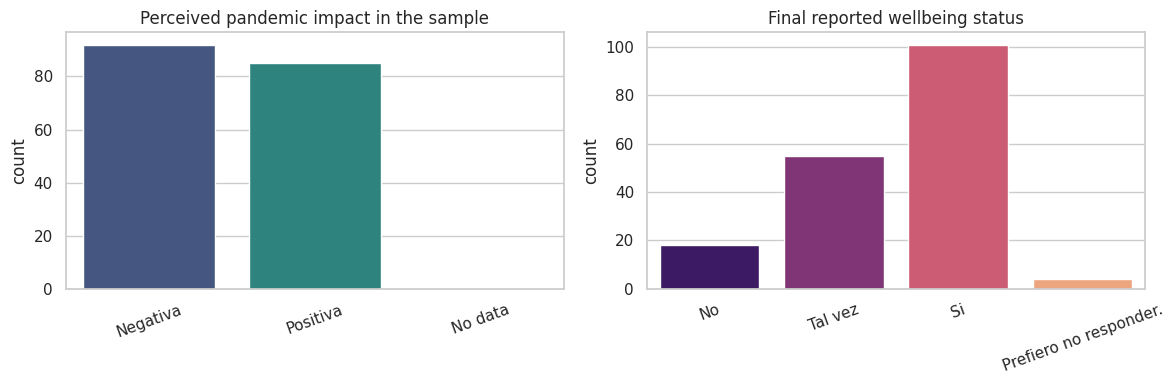

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

impact_order = df['q3_impact'].fillna('No data').value_counts().index
sns.countplot(data=df, x='q3_impact', order=impact_order, ax=axes[0], palette='viridis')
axes[0].set_title('Perceived pandemic impact in the sample')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=20)

well_order = ['No', 'Tal vez', 'Si', 'Prefiero no responder.']
well_series = df['q15_wellbeing_final'].fillna('No data')
well_order = [x for x in well_order if x in well_series.unique()] + [x for x in well_series.unique() if x not in well_order]
sns.countplot(x=well_series, order=well_order, ax=axes[1], palette='magma')
axes[1].set_title('Final reported wellbeing status')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()


In [5]:
def chi_square(data, a, b):
    sub = data[[a, b]].dropna()
    table = pd.crosstab(sub[a], sub[b])
    chi2, p_value, dof, _ = chi2_contingency(table)
    return chi2, p_value, dof, len(sub)

tests = []
chi2, p, dof, n = chi_square(df, 'q3_impact', 'q15_wellbeing_final')
tests.append(['q3_impact vs q15_wellbeing_final', chi2, p, dof, n])
chi2, p, dof, n = chi_square(df, 'q4_problems', 'q15_wellbeing_final')
tests.append(['q4_problems vs q15_wellbeing_final', chi2, p, dof, n])

tmp = df.copy()
tmp['anxiety_high'] = np.where(tmp['q14_anxiety_score'] >= 3, 'High', 'Not high')
chi2, p, dof, n = chi_square(tmp, 'q4_problems', 'anxiety_high')
tests.append(['q4_problems vs anxiety_high', chi2, p, dof, n])

chi_df = pd.DataFrame(tests, columns=['Test', 'Chi2', 'p-value', 'dof', 'n'])
chi_df['Significant (alpha=0.05)'] = chi_df['p-value'] < 0.05
chi_df


,Test,Chi2,p-value,dof,n,Significant (alpha=0.05)
0,q3_impact vs q15_wellbeing_final,4.178588,0.242814,3,177,False
1,q4_problems vs q15_wellbeing_final,30.417424,0.000033,6,177,True
2,q4_problems vs anxiety_high,6.732661,0.034516,2,177,True


In [6]:
from IPython.display import Markdown, display

k = dict(zip(kpi_df['Indicator'], kpi_df['Value']))
sig = chi_df[chi_df['Significant (alpha=0.05)'] == True]['Test'].tolist()

lines = []
lines.append('## Executive Reading')
lines.append('')
lines.append(f"- The dataset includes **{int(k['Responses analyzed'])} responses** (2021).")
lines.append(f"- **Negative perceived impact** appears in **{k['% perceived negative impact']}%** of the sample.")
lines.append(f"- **Problem reporting** reaches **{k['% reporting problems (q4=Si)']}%**.")
lines.append(f"- The **at-risk final wellbeing segment (No/Tal vez)** represents **{k['% at-risk final wellbeing (No/Tal vez)']}%**.")
if sig:
    lines.append('- Significant associations detected:')
    for s in sig:
        lines.append(f"  - `{s}`")
lines.append('')
lines.append('**Conclusion:** useful case to demonstrate professional Data Analyst methodology on historical real data.')

display(Markdown('\n'.join(lines)))


## Executive Reading

- The dataset includes **178 responses** (2021).
- **Negative perceived impact** appears in **51.98%** of the sample.
- **Problem reporting** reaches **67.23%**.
- The **at-risk final wellbeing segment (No/Tal vez)** represents **41.01%**.
- Significant associations detected:
  - `q4_problems vs q15_wellbeing_final`
  - `q4_problems vs anxiety_high`

**Conclusion:** useful case to demonstrate professional Data Analyst methodology on historical real data.